In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Só muda o jeito de printar
np.set_printoptions(precision=3,suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing

In [3]:
# https://archive.ics.uci.edu/ml/datasets/Auto+MPG
# É um dataset que contem várias informações de carros!
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names, na_values='?',
                      comment='\t', sep=' ', skipinitialspace=True)



In [4]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
# Limpando os Dados
dataset = dataset.dropna()

# Converte a Origem em USA,EUROPA,JAPÃO pelos números na origem
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1
dataset['Europe'] = (origin == 2)*1
dataset['Japan'] = (origin == 3)*1

<ipython-input-5-2fc19ff53939>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['USA'] = (origin == 1)*1
<ipython-input-5-2fc19ff53939>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Europe'] = (origin == 2)*1
<ipython-input-5-2fc19ff53939>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [6]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


In [7]:
# Divide os Dados entre Treino e Teste
train_dataset = dataset.sample(frac=0.8, random_state=0) # 80% para treino
test_dataset = dataset.drop(train_dataset.index) # 20% para teste

print(dataset.shape, train_dataset.shape, test_dataset.shape)
train_dataset.describe().transpose()

(392, 10) (314, 10) (78, 10)


,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [8]:
# Faz uma copia
train_features = train_dataset.copy()
test_features = test_dataset.copy()
# Recebe o rotulo MPG
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')
# lembrando que o metodo .pop() retorna o valor que foi apagado


In [9]:
# Função para Plotar
def plot(rotulo, x=None, y=None):
    plt.figure(figsize=(10, 8)) # Define o tamanho
    plt.scatter(train_features[rotulo], train_labels, label='Data') # scatter para um grafico de dispersão
    if x is not None and y is not None: # se x tem um valor e y tem um valor
        plt.plot(x, y, color='k', label='Predictions') # plota x e y
    plt.xlabel(rotulo)
    plt.ylabel('MPG')
    plt.legend()

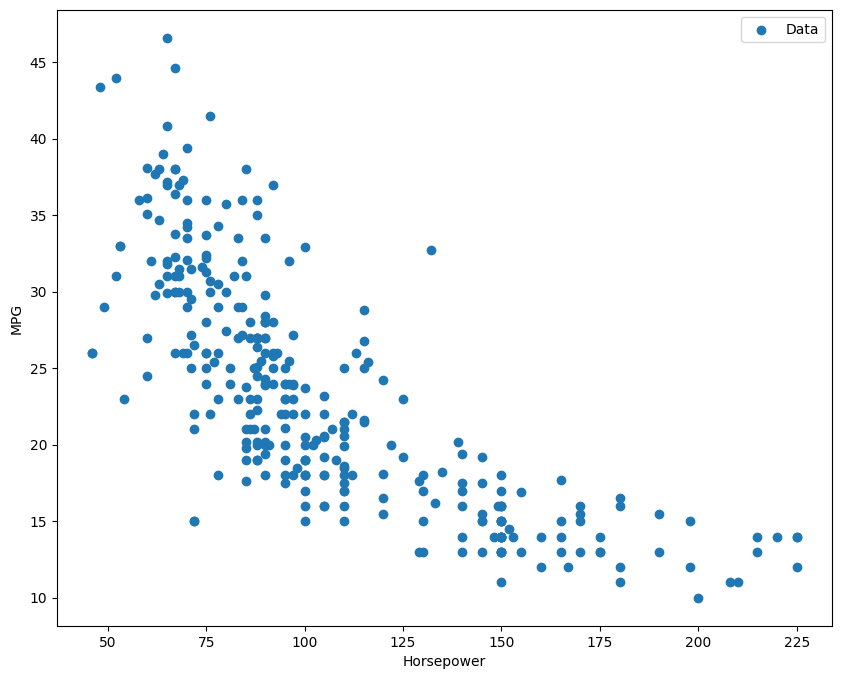

In [10]:
plot('Horsepower')

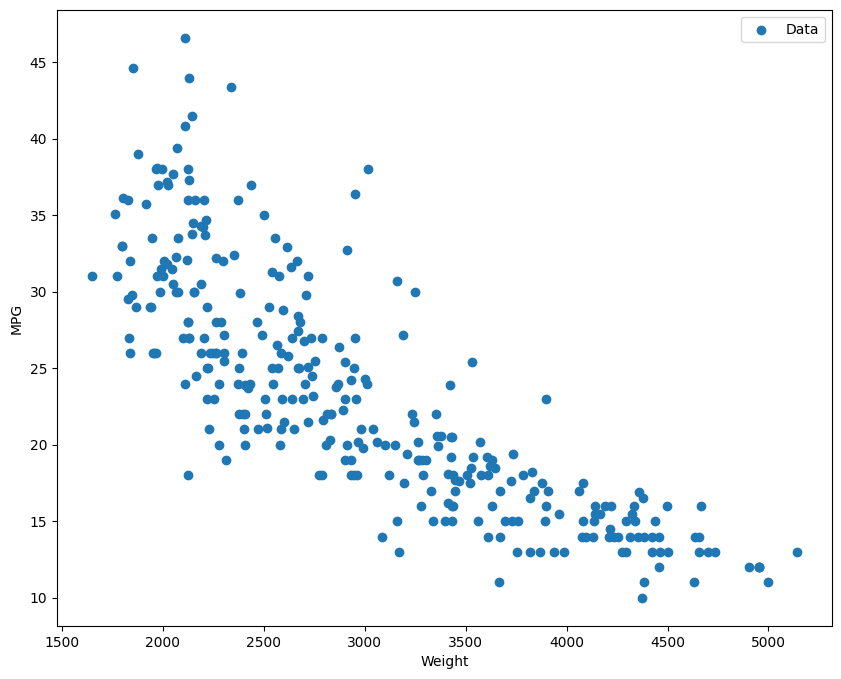

In [11]:
plot('Weight')

Como visto anteriormente na coluna mean, os valores vão de 0.178344 até 2990.251592, então precisamos normalizar eles
para resolver esse desbalanceamento

In [12]:
# Normalizando
print(train_dataset.describe().transpose()[['mean','std']])

# Normalização:

normalizer = tf.keras.layers.Normalization()

# adaptando para os dados
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

                     mean         std
MPG             23.310510    7.728652
Cylinders        5.477707    1.699788
Displacement   195.318471  104.331589
Horsepower     104.869427   38.096214
Weight        2990.251592  843.898596
Acceleration    15.559236    2.789230
Model Year      75.898089    3.675642
USA              0.624204    0.485101
Europe           0.178344    0.383413
Japan            0.197452    0.398712
[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.624    0.178
     0.197]]


In [13]:
# Quando a camada é chamada, ela retorna os dados que foram inputados,
# com cada seção normalizada independentemente
#formula da normalização: (dado - media) / desvio padrão

first = np.array(train_features[:1])
print("Primeiro Exemplo:\n",first)
print("Normalizado:\n",normalizer(first).numpy())


Primeiro Exemplo:
 [[   4.    90.    75.  2125.    14.5   74.     1.     0.     0. ]]
Normalizado:
 [[-0.871 -1.011 -0.785 -1.027 -0.38  -0.517  0.776 -0.466 -0.496]]


In [14]:
# Problema de Regressão
    # 1. Normalize o input de Horsepower
    # 2. Aplique uma transformação linear (y = m*x+b) para produzir 1 output usando layers.Dense

feature = 'Horsepower' # pode ser qualquer um
single_feature = np.array(train_features[feature]) # single_feature = array dos dados de feature em train_features['feature']
print(single_feature.shape, train_features.shape)

# Normalizando os dados
single_feature_normalizer = tf.keras.layers.Normalization(axis=-1,input_shape=(1,)) # Normaliza usando (dado - media) / desvio padrão

# Adapta para os dados. Calcula media e desvio padrão
single_feature = single_feature.reshape(-1,1)
single_feature_normalizer.adapt(single_feature)


(314,) (314, 9)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# Modelo Sequencial

single_feature_model = keras.models.Sequential([
    single_feature_normalizer, # passa o modelo como parametro
    layers.Dense(units=1,input_shape=(1,)) # Modelo de Regressão Linear -> 1 UNIT = 1 Neuronio = 1 OUTPUT
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
single_feature_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization)      │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

In [17]:
#Perdas e otimizações

loss = keras.losses.MeanAbsoluteError() # Bom com o modelo de regressão linear # MeanSquaredError

# Reg = m*x + b >>> Erro = Reg - y
# MeanAbsoluteError -> Faz o somatório do módulo dos erros
# MeanSquaredError -> Faz o somatório do quadrado dos erros ( como no seu caderno )

optimizer = keras.optimizers.Adam(learning_rate=0.1)

single_feature_model.compile(optimizer=optimizer, loss=loss) # A acuracia não faz sentido para a Regressão Linear

<br>
<h1> Regressão Linear / Gradiente Descentente </h1>
<p> A taxa de variação (derivada) calculada no ponto da reta em vermelho é maior do que no ponto minímo</p>
<p> E posteriormente m = m - (derivada parcial de Custo em M) </p>
<p> E posteriormente b = b - (derivada parcial de Custo em B)</p>
<p> Para Cada Iteração o valor decrementado por derivada será menor, o que permite passos longos com um m/b muito errado e curtos para m/b mais precisos</p>
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*AZzu43KoxDamVpWMVW0zfw.png">
</br>

In [18]:
history = single_feature_model.fit( # .fit() retorna os valores
    train_features[feature], train_labels, # train_features para um feature de cada vez
    epochs = 100,
    verbose = 1,
    validation_split = 0.2 ) # 20% dos dados do treinamento serão separados, e usados para atualizar os parametros que no caso sao m e b

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 22.4665 - val_loss: 22.9378
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 22.3881 - val_loss: 22.1378
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 21.2714 - val_loss: 21.3377
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 20.8599 - val_loss: 20.5376
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 19.8021 - val_loss: 19.7375
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 18.8524 - val_loss: 18.9376
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 18.3592 - val_loss: 18.1377
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 17.4513 - val_loss: 17.3377
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 16.7542 - val_loss: 16.5375
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 16.6740 - val_loss: 15.7373
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 14.8719 - val_loss: 14.9389
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 

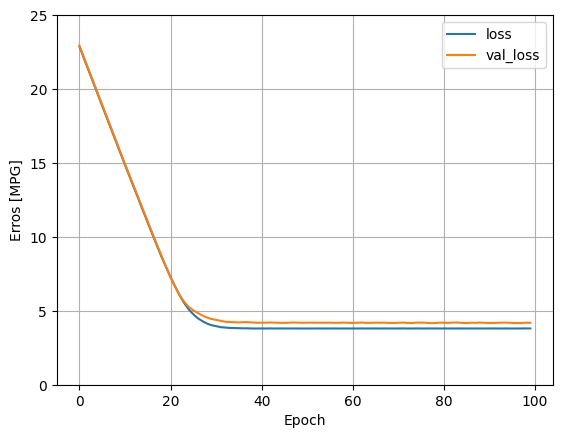

In [19]:
# plota a perda
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 25])
    plt.xlabel('Epoch')
    plt.ylabel('Erros [MPG]')
    plt.legend()
    plt.grid(True)
plot_loss(history)

In [20]:
single_feature_model.evaluate(
    test_features[feature],
    test_labels, verbose=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5693 


3.64729380607605

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


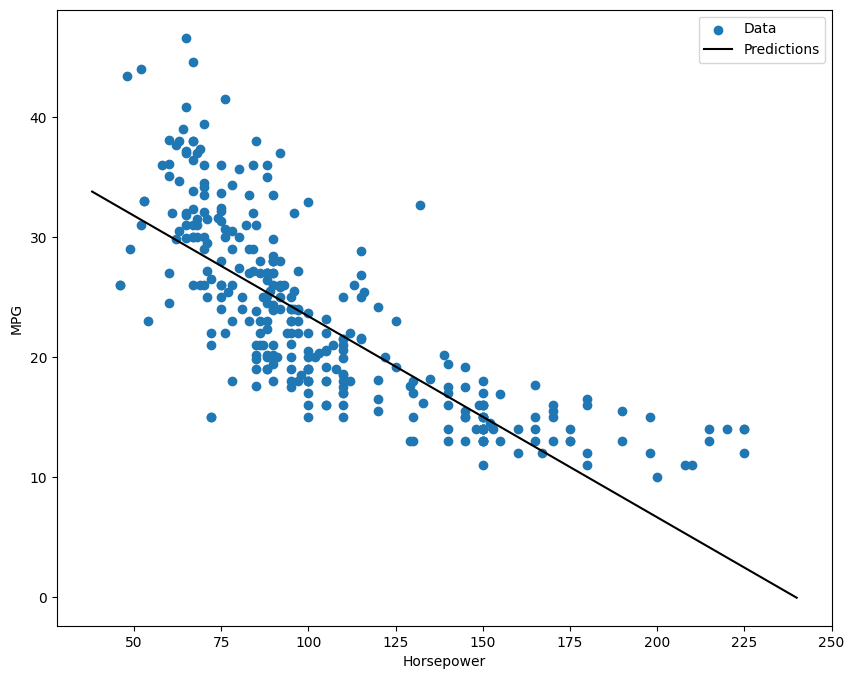

In [21]:
# Plota a Reta que prevê o gráfico
range_min = np.min(test_features[feature]) - 10
range_max = np.max(test_features[feature]) + 10
x = tf.linspace(range_min, range_max, 200) # eixo x vai de um valor minimo - 10 até um valor maximo + 10
y = single_feature_model.predict(x) # x é o dado atual ela preve pela equação y = mx+b pra cada valor de x

plot(feature, x,y) # feature pode ser horsepower, cilindros,etc

In [22]:
# Agora Extendendo Para Deep Neural Networking
dnn_model = keras.Sequential([
    single_feature_normalizer,
    # MEIO
        # relu -> f(x) = max(0,x) se x > 0 retorna x, se x < 0 retorna 0

    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),

    # FIM
    layers.Dense(1) # lembrando 1 neuronio = 1 output
])
# Agora é so fazer a mesma coisa, compilar, treinar e plotar


In [23]:
dnn_model.compile(loss=loss,
                  optimizer = tf.keras.optimizers.Adam(0.001))
dnn_model.summary()
# com o output do sumario, da pra ver que

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization)      │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

In [24]:
# treinando
dnn_model.fit(
    train_features[feature], train_labels,
    validation_split = 0.2,
    verbose = 1, epochs = 100
) # Observe que o código pra deep neural network é quase a mesma coisa, só adiciona mais camadas de layers.Dense()


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 23.0701 - val_loss: 23.4599
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 22.8617 - val_loss: 23.1784
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 22.9480 - val_loss: 22.8587
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22.2011 - val_loss: 22.4571
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22.1387 - val_loss: 21.9494
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.1502 - val_loss: 21.2892
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.9990 - val_loss: 20.4633
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 19.7651 - val_loss: 19.4929
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18.9252 - val_loss: 18.4001
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.9992 - val_loss: 17.3772
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.0162 - val_loss: 16.3723
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15

In [25]:
# Esta menor que 3, então definitavamente esta melhor
dnn_model.evaluate(test_features[feature],test_labels, verbose = 1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7627 


2.8885514736175537

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


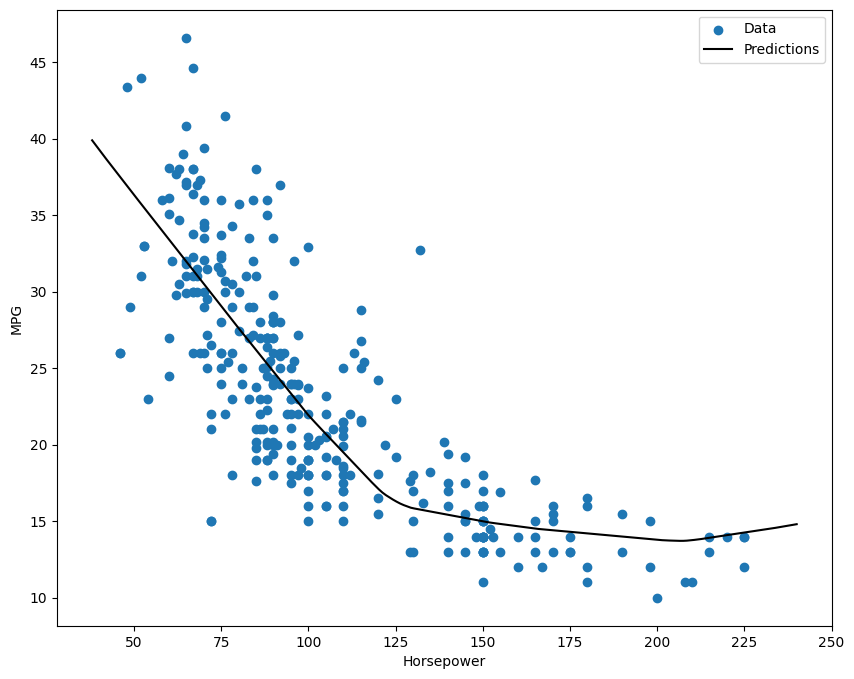

In [26]:
# Plotando e prevendo

x = tf.linspace(range_min, range_max, 200)
y = dnn_model.predict(x) # pro valor do x prevê um y -> y = mx + b

plot(feature, x,y)
# Aqui a previsão é não linear

In [53]:
# multiplos inputs

linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate = 0.001),
    loss = loss)


In [54]:
linear_model.fit(
    train_features, train_labels,
    epochs = 100,
    verbose = 1,
    # Calcula os resultados de validação com 20% dos dados de treinamento
    validation_split = 0.2)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 22.8028 - val_loss: 23.7472
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 23.5545 - val_loss: 23.7396
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22.8299 - val_loss: 23.7323
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22.8087 - val_loss: 23.7252
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.3661 - val_loss: 23.7176
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 23.8767 - val_loss: 23.7101
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 22.6959 - val_loss: 23.7029
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 23.2485 - val_loss: 23.6958
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 23.0038 - val_loss: 23.6887
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23.4947 - val_loss: 23.6814
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 23.0001 - val_loss: 23.6742
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss:

In [55]:
linear_model.evaluate(
    # Ele recebe como argumento os dados que foram separados no início do código
    test_features, test_labels, verbose=2)

3/3 - 0s - 10ms/step - loss: 23.1320


23.132007598876953